In [2]:
import os
import pickle
from tqdm import tqdm, trange
import os
import numpy as np
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
sns.set_style("darkgrid")
import matplotlib.cm as cm

In [4]:
binding = True
root_path = '/home/alexander/ray_results/cross_play_20K_episodes_binding/2021_03_23/12_37_37'

# binding = False
# root_path = 'home/alexander/ray_results/cross_play_20K_episodes_cheap/2021_03_24/05_30_06'

# root_path = '/home/alexander/ray_results/population_experiments/2021_04_20/14_01_26'
# binding = True

# binding = True
# root_path = '/home/alexander/ray_results/cross_play_20K_episodes_binding_prosocial/2021_05_20/01_53_31'

binding = True
root_path = '/home/alexander/ray_results/cross_play_20K_episodes_binding_prosocial/2021_05_31/23_44_35'  # not actually prosocial

# results_filename = os.path.join('cross_play_evals', 'results_' + '_'.join(root_path.split('/')[-3:]) + '.pickle')  # new experimental file
# results_filename = os.path.join('cross_play_evals', 'results_' + '_'.join(root_path.split('/')[-3:]) + '_b.pickle')  # the default file
results_filename = os.path.join('cross_play_evals', 'results_' + '_'.join(root_path.split('/')[-3:]) + '.pickle')
results = pickle.load(open(results_filename, 'rb'))

res_dict = defaultdict(list)

for res in results:
    res_dict[(res[0], res[1])].append(res[3])

In [89]:
len(results)

8870

In [91]:
# res2 = [res for res in results if res[0] == ('custom_vs_custom_1', 'custom_vs_custom_2') and res[1] == 0]

In [89]:
# res2[0][3]['player0_share_of_max'].shape

In [90]:
# pickle.dump(open('prev_results_'))

In [40]:
img_dir = results_filename[:-7]
os.makedirs(img_dir, exist_ok=True)

# Plot welfare in cross-play

In [ ]:
for eval_regime_name, eval_regime_list in [
    ('agents of the same type', 
        (
            ('custom_vs_custom_1', 'custom_vs_custom_1'),  # normal eval
            ('custom_vs_custom_1', 'custom_vs_custom_2'),  # simplest (1)
        )
    ),
    ('both have incorrect notions',
        (
           ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
           ('default_vs_default', 'custom_vs_custom_1'),   # 2.2
            
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
           ('default_vs_default', 'default_vs_default'),
        ),
    ),
    ('second has incorrect notions',
        (
           ('default_vs_custom', 'custom_vs_custom_1'),   # 3.1
           ('custom_vs_custom_1', 'default_vs_custom'),  # 4.1
           ('default_vs_default', 'custom_vs_default'),
           ('custom_vs_default', 'default_vs_default'),
            
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
        ),
    ),
    ('first has incorrect notions',
        (
           ('default_vs_default', 'default_vs_custom'),   # 3.2
           ('default_vs_custom', 'default_vs_default'),  # 4.2
           ('custom_vs_default', 'custom_vs_custom_1'),
           ('custom_vs_custom_1', 'custom_vs_default'),
            
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
        ),
    ),
]:
    for xlabel, xarray, yarray in [
        ('Utilities skew', np.arange(-1, 1.1, 0.4), np.arange(1, 7)),
        ('Fairness coeff', np.arange(0.0, 0.7, 0.1), np.arange(7, 14)),
        ('Prosociality level', np.arange(0, 1.1, 0.2), np.arange(14, 20)),
        ('Hidden layer size', [5, 10, 20, 40, 80, 160], np.arange(20, 26))
    ]:
        plt.figure(figsize=(10, 7))
        for agent_0_match_regime, agent_1_match_regime in eval_regime_list:
            welfare_vals = []
            welfare_stds = []
#             welfare_positive_vals = []
#             welfare_positive_stds = []
            for y in yarray:
                vals = np.array([res['sum_share_of_max'] for res in res_dict[((agent_0_match_regime, agent_1_match_regime), y)]])
                welfare_vals.append(vals.mean())
                welfare_stds.append(vals.mean(axis=1).std())
#                 welfare_positive = (vals > 0)
#                 welfare_positive_vals.append(welfare_positive.mean())
#                 welfare_positive_stds.append(welfare_positive.mean(axis=1).std())
            plt.scatter(xarray, welfare_vals,
                        label=f'{agent_0_match_regime}, {agent_1_match_regime}')
            plt.errorbar(xarray, welfare_vals, yerr=welfare_stds)
#             plt.scatter(xarray, welfare_positive_vals,
#                         label=f'{agent_0_match_regime}, {agent_1_match_regime}')
#             plt.errorbar(xarray, welfare_positive_vals, yerr=welfare_positive_stds)
            plt.ylim(0.3, 1)
            plt.ylabel('Welfare, share of maximum possible welfare')
#             plt.ylabel('% of positive-welfare games')
            plt.xlabel(xlabel)
            suptitle = f'Welfare vs {xlabel}, {"Binding comms" if binding else "cheap comms"}, {eval_regime_name}'
            plt.suptitle(suptitle)
            plt.legend()
            plt.savefig(os.path.join(img_dir, suptitle + '.png'), bbox_inches='tight')
os.system(f'tar -czvf {img_dir}.tar {img_dir}')

# this is just for computing the multiplier for normalization on Maxime barplot

In [108]:
from itertools import product

In [109]:
from marltoolbox.algos.alternating_offers.envs.alt_offers_env_sampling import generate_batch

In [85]:
max_sums = []
for i in range(50):
    batch = generate_batch(128, ('uniform', 'uniform'))
    for i in range(batch['pool'].numpy().shape[0]):
        p = batch['pool'][i].numpy()
        u0 = batch['utilities'][0][i].numpy()
        u1 = batch['utilities'][1][i].numpy()

        theor0 = (p*u0).sum()
        theor1 = (p*u1).sum()

        max_sum = 0
        for dist in product(range(p[0]+1), range(p[1]+1), range(p[2]+1)):
            cur_sum = 0
            if theor0 != 0:
                cur_sum += (u0 * dist / theor0).sum()
            if theor1 != 0:
                cur_sum += (u1 * (p-dist) / theor1).sum()
            max_sum = max(cur_sum, max_sum)
        max_sums.append(max_sum)

In [86]:
np.array(max_sums).mean() / 2

0.6600224200927554

In [74]:
max_sum = 0
for dist in product(range(p[0]+1), range(p[1]+1), range(p[2]+1)):
    cur_sum = (u0 * dist / theor0).sum() + (u1 * (p-dist) / theor1).sum()
    max_sum = max(cur_sum, max_sum)

In [75]:
max_sum

1.4642857142857144

In [44]:
ia_max_payoffs = []
for ia_i, ia in enumerate(np.array(list(range(0, 7))) / 10):
    cur_ia_max_payoffs = []
    for batch_i in range(2):
        batch = generate_batch(128, ('uniform', 'uniform'))
        for i in range(batch['pool'].numpy().shape[0]):
            p = batch['pool'][i].numpy()
            u0 = batch['utilities'][0][i].numpy()
            u1 = batch['utilities'][1][i].numpy()

            theor0 = (p*u0).sum()
            theor1 = (p*u1).sum()

            max_payoffs = None
            max_w = None
            for dist in product(range(p[0]+1), range(p[1]+1), range(p[2]+1)):
                p0 = 0
                p1 = 0
                if theor0 != 0:
                    p0 = (u0 * dist / theor0).sum()
                if theor1 != 0:
                    p1 = (u1 * (p-dist) / theor1).sum()
                w = p0 + p1 - abs(p0-p1) * ia
                if max_payoffs is None or (w>max_w):
                    max_w = w
                    max_payoffs = (p0, p1)
            cur_ia_max_payoffs.append(max_payoffs)
    cur_ia_max_payoffs = np.array(cur_ia_max_payoffs).mean(axis=0)
    ia_max_payoffs.append(cur_ia_max_payoffs)

In [45]:
ia_max_payoffs

[array([0.61280657, 0.69603168]),
 array([0.64512356, 0.68655664]),
 array([0.63628684, 0.6816643 ]),
 array([0.632787  , 0.67854254]),
 array([0.62390487, 0.67512828]),
 array([0.65146122, 0.64038926]),
 array([0.6425503 , 0.65451186])]

In [130]:
ia_val_w_maximums = []
for ia_val in (np.array(list(range(0, 7))) / 10):
    max_sums = []
    for i in range(10):
        batch = generate_batch(128, ('uniform', 'uniform'))
        for i in range(batch['pool'].numpy().shape[0]):
            p = batch['pool'][i].numpy()
            u0 = batch['utilities'][0][i].numpy()
            u1 = batch['utilities'][1][i].numpy()

            theor0 = (p*u0).sum()
            theor1 = (p*u1).sum()
#             print(theor0)
#             print(theor1)
            max_sum = 0
            for dist in product(range(p[0]+1), range(p[1]+1), range(p[2]+1)):
                cur_sum = 0
                cur_0 = 0
                cur_1 = 0
                if theor0 != 0:
                    cur_0 = (u0 * dist / theor0).sum()  # 0 value
                if theor1 != 0:
                    cur_1 = (u1 * (p-dist) / theor1).sum()  # 1 value
                cur_sum = cur_0 + cur_1 - ia_val * np.abs(cur_0 - cur_1)
                max_sum = max(cur_sum, max_sum)
#                 print(cur_sum)
            max_sums.append(max_sum)
    ia_val_w_maximums.append(np.array(max_sums).mean())

# Same but only for particular runs and with num_turns as well

In [19]:
# res_dict[(('default_vs_default', 'custom_vs_custom_1'), 8)]

In [ ]:
# agent_0_match_regime, agent_1_match_regime = ('default_vs_default', 'custom_vs_custom_1')
# agent_0_match_regime, agent_1_match_regime = ('custom_vs_custom_1', 'default_vs_default')
agent_0_match_regime, agent_1_match_regime = ('custom_vs_custom_1', 'custom_vs_custom_2')
for array_i in range(7, 14):
    r0 = np.array([res['player0_share_of_max'] for res in res_dict[((agent_0_match_regime, agent_1_match_regime), array_i)]]).flatten()
    r1 = np.array([res['player1_share_of_max'] for res in res_dict[((agent_0_match_regime, agent_1_match_regime), array_i)]]).flatten()
    w = np.array([res['sum_share_of_max'] for res in res_dict[((agent_0_match_regime, agent_1_match_regime), array_i)]]).flatten()
    num_turns = np.array([res['num_turns'] for res in res_dict[((agent_0_match_regime, agent_1_match_regime), array_i)]]).flatten()
#     sns.displot(w, binwidth=0.3)

#     plt.figure(figsize=(10, 7,))
    sns.displot(w, height=9)
    suptitle = f"welfare distribution, ('{agent_0_match_regime}', '{agent_1_match_regime}'), IA coeff {np.arange(0.0, 0.7, 0.1)[array_i-7]:.1f}"
    plt.suptitle(suptitle)
    plt.savefig(os.path.join('debug', suptitle + '.png'), bbox_inches='tight')
    
#     plt.figure(figsize=(10, 7,))
    sns.displot(num_turns, binwidth=0.3, height=9)
    suptitle = f"num_turns distribution, ('{agent_0_match_regime}', '{agent_1_match_regime}'), IA coeff {np.arange(0.0, 0.7, 0.1)[array_i-7]:.1f}"
    plt.suptitle(suptitle)
#     plt.savefig(os.path.join('debug', suptitle + '.png'), bbox_inches='tight')
    
# os.system(f'tar -czvf debug.tar debug')

# Now plot agent payoffs instead of welfare for cross-play

In [ ]:
for eval_regime_name, eval_regime_list in [
    ('both have incorrect notions',
        (
           ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
           ('default_vs_default', 'custom_vs_custom_1'),   # 2.2
            
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
        ),
    ),
    ('second has incorrect notions',
        (
           ('default_vs_custom', 'custom_vs_custom_1'),   # 3.1
           ('custom_vs_custom_1', 'default_vs_custom'),  # 4.1
           ('default_vs_default', 'custom_vs_default'),
           ('custom_vs_default', 'default_vs_default'),
            
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
        ),
    ),
    ('first has incorrect notions',
        (
           ('default_vs_default', 'default_vs_custom'),   # 3.2
           ('default_vs_custom', 'default_vs_default'),  # 4.2
           ('custom_vs_default', 'custom_vs_custom_1'),
           ('custom_vs_custom_1', 'custom_vs_default'),
            
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
        ),
    ),
]:
    for xlabel, xarray, yarray in [
        ('Utilities skew', np.arange(-1, 1.1, 0.4), np.arange(1, 7)),
        ('Fairness coeff', np.arange(0.0, 0.7, 0.1), np.arange(7, 14)),
        ('Prosociality level', np.arange(0, 1.1, 0.2), np.arange(14, 20)),
        ('Hidden layer size', [5, 10, 20, 40, 80, 160], np.arange(20, 26))
    ]:
        plt.figure(figsize=(10, 7))
        for agent_0_match_regime, agent_1_match_regime in eval_regime_list:
            reward_names = []
            if agent_0_match_regime.startswith('custom'):
                reward_names.append('player0_share_of_max')
            if agent_1_match_regime.endswith('custom') or agent_1_match_regime.endswith('custom_1') \
                or agent_1_match_regime.endswith('custom_2'):
                reward_names.append('player1_share_of_max')
            for reward_name in reward_names:
                welfare_vals = []
                welfare_stds = []
                for y in yarray:
                    vals = np.array([res[reward_name] for res in res_dict[((agent_0_match_regime,
                                                                            agent_1_match_regime), y)]])
                    welfare_vals.append(vals.mean())
                    welfare_stds.append(vals.mean(axis=1).std())
                plt.scatter(xarray, welfare_vals,
                            label=f'{agent_0_match_regime}, {agent_1_match_regime}, {reward_name}')
                plt.errorbar(xarray, welfare_vals, yerr=welfare_stds)
                plt.ylabel('Agent value')
                plt.xlabel(xlabel)
                suptitle = f'Value vs {xlabel}, {"Binding comms" if binding else "cheap comms"}, {eval_regime_name}'
                plt.suptitle(suptitle)
                plt.legend()
                plt.savefig(os.path.join(img_dir, suptitle + '.png'), bbox_inches='tight')
os.system(f'tar -czvf {img_dir}.tar {img_dir}')

# Player 0 vs player 1 payoff plots in cross-play and self-play

In [26]:
# len(res_dict[(('custom_vs_custom_1', 'custom_vs_custom_1'), 1)])

In [27]:
# list(res_dict.keys())

In [5]:
all_vals = []
for eval_regime_name, eval_regime_list in [
    ('placeholder_name',
        (
#            ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
           ('default_vs_default', 'custom_vs_custom_1'),   # 2.2
            
           ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
           ('custom_vs_custom_1', 'custom_vs_custom_1'),  # as baseline
        ),
    ),
#     ('second has incorrect notions',
#         (
#            ('default_vs_custom', 'custom_vs_custom_1'),   # 3.1
#            ('custom_vs_custom_1', 'default_vs_custom'),  # 4.1
#            ('default_vs_default', 'custom_vs_default'),
#            ('custom_vs_default', 'default_vs_default'),
            
# #            ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
#         ),
#     ),
#     ('first has incorrect notions',
#         (
#            ('default_vs_default', 'default_vs_custom'),   # 3.2
#            ('default_vs_custom', 'default_vs_default'),  # 4.2
#            ('custom_vs_default', 'custom_vs_custom_1'),
#            ('custom_vs_custom_1', 'custom_vs_default'),
            
# #            ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
#         ),
#     ),
]:
    for xlabel, xarray, yarray in [
#         ('Utilities skew', np.arange(-1, 1.1, 0.4), np.arange(1, 7)),
        ('Fairness coeff', np.arange(0.0, 0.7, 0.1), np.arange(7, 14)),
#         ('Prosociality level', np.arange(0, 1.1, 0.2), np.arange(14, 20)),
#         ('Hidden layer size', [5, 10, 20, 40, 80, 160], np.arange(20, 26))
    ]:
        for agent_0_match_regime, agent_1_match_regime in eval_regime_list:
            for i, array_pos in enumerate(yarray):
#                 if not (agent_0_match_regime, agent_1_match_regime) == ('custom_vs_custom_1', 'custom_vs_custom_2') \
#                    and i == 0:
#                     continue
#                 if (agent_0_match_regime, agent_1_match_regime) == ('custom_vs_custom_1', 'custom_vs_custom_2'):
#                     cross_play = False
#                 else:
#                     cross_play = True  # in the strong sense, meaning that value functions are different
                cross_play = None
    
                vals = np.array([res['player0_share_of_max'] for res in res_dict[((agent_0_match_regime,
                                                                        agent_1_match_regime), array_pos)]])
                x = vals.mean()
                x_std = vals.std()
                vals = np.array([res['player1_share_of_max'] for res in res_dict[((agent_0_match_regime,
                                                                        agent_1_match_regime), array_pos)]])
                y = vals.mean()
                y_std = vals.std()
#                 suptitle = f'Value vs {xlabel}, {"Binding comms" if binding else "cheap comms"}, {eval_regime_name}'
#                 print(suptitle, agent_0_match_regime, agent_1_match_regime, reward_name)
                all_vals.append((x, y, x_std, y_std, xarray[i], binding, cross_play))
#                 print(x, xarray[i])
# os.system(f'tar -czvf {img_dir}.tar {img_dir}')

x, y, x_std, y_std, param_val, binding_param, cross_play = zip(*all_vals)

In [6]:
len(x)

21

In [ ]:
# ('default_vs_default', 'custom_vs_custom_1'),  # 1:7
# ('custom_vs_custom_1', 'custom_vs_custom_2'),  # 7:14

# # plt.switch_backend("agg")
# plt.style.use("seaborn-whitegrid")
# COLORS = list(mcolors.TABLEAU_COLORS) + list(mcolors.XKCD_COLORS)
# COLORS = list(mcolors.TABLEAU_COLORS)[:6] + ['black',] + list(mcolors.TABLEAU_COLORS)[:6]
# RANDOM_MARKERS = ["1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+"]
# MARKERS = ["o", "s", "v", "^", "<", ">", "P", "X", "D", "*"] + RANDOM_MARKERS

# plt.figure(figsize=(11, 6))
# # plt.figure(figsize=(8, 5))
# # for i in range(len(x)):
# for i in range(13):
#     label = f"{'cross-play' if cross_play[i] else 'self-play'}, IA coeff = {param_val[i]:.1f}"
#     if not cross_play[i]:
#         label = f'IA = {param_val[i]:.1f} vs. IA = {param_val[i]:.1f}'
#     else:
#         label = f'IA = 0.0 vs. IA = {param_val[i]:.1f}'
#     color_list = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9',   '#000000', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9',]
# #     marker_list = ['<', '>', 'X', '*', 'P', 's',   'd', '<', '>', 'X', '*', 'P', 's']
#     marker_list = ['*',]*6 + ['s',]*7
#     s = 80 if cross_play[i] else 300
#     plt.plot(
#         x[i],
#         y[i],
# #         markerfacecolor="none",
#         markeredgecolor=COLORS[i],
#         linestyle="None",
#         marker=marker_list[i],
#         color=COLORS[i],
#         label=label,
#         markersize=9 if marker_list[i] == 's' else 13
#     )
    
# plt.xlabel('Player 0 value', fontsize=17)
# plt.ylabel('Player 1 value', fontsize=17)
# plt.xlim((0.23, 0.75))
# plt.ylim((0.23, 0.75))
# plt.suptitle(f'Average values of agents', fontsize=17)
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), numpoints=1,
#     frameon=True,
#     fontsize=11,)
# #     fontsize="small",)
# plt.show()

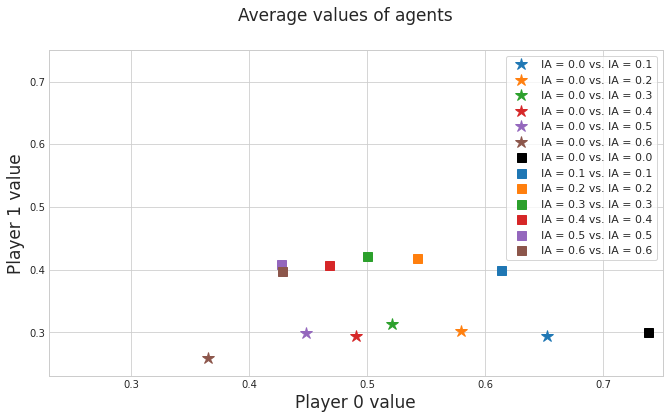

In [33]:
('default_vs_default', 'custom_vs_custom_1'),  # display 1:7
('custom_vs_custom_1', 'custom_vs_custom_2'),  # display 7:14

# plt.switch_backend("agg")
plt.style.use("seaborn-whitegrid")
COLORS = [None,] + list(mcolors.TABLEAU_COLORS)[:6] + ['black',] + list(mcolors.TABLEAU_COLORS)[:6]
RANDOM_MARKERS = [None, "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+"]
marker_list = [None,] + ['*',]*6 + ['s',]*7

plt.figure(figsize=(11, 6))
# plt.figure(figsize=(8, 5))
# for i in range(len(x)):
for i in range(1, 14):
    if i >= 7:
        label = f'IA = {param_val[i]:.1f} vs. IA = {param_val[i]:.1f}'
    else:
        label = f'IA = 0.0 vs. IA = {param_val[i]:.1f}'
    color_list = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9',   '#000000', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9',]
#     marker_list = ['<', '>', 'X', '*', 'P', 's',   'd', '<', '>', 'X', '*', 'P', 's']
    s = 80 if cross_play[i] else 300
    plt.plot(
        x[i],
        y[i],
#         markerfacecolor="none",
        markeredgecolor=COLORS[i],
        linestyle="None",
        marker=marker_list[i],
        color=COLORS[i],
        label=label,
        markersize=9 if marker_list[i] == 's' else 13
    )
    
plt.xlabel('Player 0 value', fontsize=17)
plt.ylabel('Player 1 value', fontsize=17)
plt.xlim((0.23, 0.75))
plt.ylim((0.23, 0.75))
plt.suptitle(f'Average values of agents', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), numpoints=1,
    frameon=True,
    fontsize=11,)
#     fontsize="small",)
plt.show()

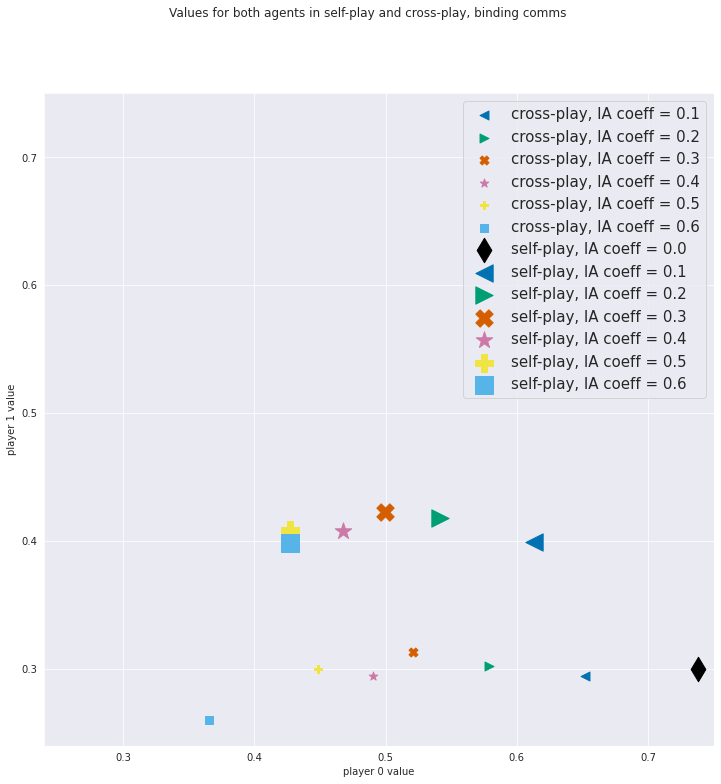

In [9]:
# plt.figure(figsize=(12, 12))
# plt.xlim((0.24, 0.75))
# plt.ylim((0.24, 0.75))
# for i in range(len(x)):
#     label = f"{'cross-play' if cross_play[i] else 'self-play'}, IA coeff = {param_val[i]:.1f}"
#     color_list = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9',   '#000000', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9',]
#     marker_list = ['<', '>', 'X', '*', 'P', 's',   'd', '<', '>', 'X', '*', 'P', 's']
#     s = 80 if cross_play[i] else 300
#     plt.scatter(x[i], y[i], label=label, color=color_list[i], marker=marker_list[i], s=s)
    
# plt.xlabel('player 0 value')
# plt.ylabel('player 1 value')
# plt.suptitle(f'Values for both agents in self-play and cross-play, {"binding comms" if binding else "cheap comms"}')
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), prop={'size': 15})

In [ ]:

# Legend
plt.legend(
    numpoints=1,
    frameon=True,
    fontsize="small",
    )
# Plotting lines
plt.plot(
    df.index,
    df[col_i],
    label=label_i,
    color=COLORS[i],
)
# Plotting points (with countours only, not filled)
plt.plot(
    x,
    y,
    markerfacecolor="none"
    markeredgecolor=COLORS[i],
    linestyle="None",
    marker=MARKERS[i],
    color=COLORS[i],
    label=label_i,
)

## Compute mean and std for barplots individually over different runs

In [ ]:
# ('default_vs_default', 'custom_vs_custom_1'),   # 2.2
# ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
# ('custom_vs_custom_1', 'custom_vs_custom_1'),  # as baseline

In [46]:
print(x[1:7], y[1:7])  # default vs custom, starts from 1

(0.651958, 0.57897437, 0.5209278, 0.4904595, 0.44816065, 0.3652433) (0.2946116, 0.30257654, 0.31327945, 0.29468426, 0.29970247, 0.25992543)


In [47]:
print(x[7:14], y[7:14])  # custom vs custom, starts from 0

(0.7376215, 0.6129167, 0.54170287, 0.4994951, 0.46781248, 0.4270572, 0.42730743) (0.30001095, 0.39960298, 0.41811663, 0.42247146, 0.40760374, 0.40898776, 0.3982173)


In [122]:
run_vals = []
for run_i in range(5):
    all_vals = []
    for eval_regime_name, eval_regime_list in [
        ('placeholder_name',
            (
    #            ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
               ('default_vs_default', 'custom_vs_custom_1'),   # 2.2

               ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
               ('custom_vs_custom_1', 'custom_vs_custom_1'),  # as baseline
            ),
        ),
    ]:
        for xlabel, xarray, yarray in [
            ('Fairness coeff', np.arange(0.0, 0.7, 0.1), np.arange(7, 14)),
        ]:
            for agent_0_match_regime, agent_1_match_regime in eval_regime_list:
                for i, array_pos in enumerate(yarray):
#                     cross_play = None

#                     vals = np.array(res_dict[((agent_0_match_regime, agent_1_match_regime), array_pos)][run_i]['player0_share_of_max'])
#                     x = vals.mean()
#                     x_std = vals.std()
#                     vals = np.array(res_dict[((agent_0_match_regime, agent_1_match_regime), array_pos)][run_i]['player1_share_of_max'])
#                     y = vals.mean()
#                     y_std = vals.std()
#                     all_vals.append((x, y, x_std, y_std, xarray[i], binding, cross_play))
                    
                    all_vals.append((np.array(res_dict[((agent_0_match_regime, agent_1_match_regime), array_pos)][run_i]['player0_share_of_max']),
                                     np.array(res_dict[((agent_0_match_regime, agent_1_match_regime), array_pos)][run_i]['player1_share_of_max'])))

    run_vals.append(all_vals)

In [123]:
np.array(run_vals).shape

(5, 21, 2, 16384)

In [124]:
run_vals = np.array(run_vals)

In [ ]:
# distances

In [95]:
all_vals = []
for ia_i in range(7):
    cur_max_payoffs = ia_max_payoffs[ia_i]
    cur_max_payoffs = cur_max_payoffs.reshape((1, 1, 2, 1))
    cur_dists = np.linalg.norm(run_vals[:, 1:7, :, :] - cur_max_payoffs, axis=2)
    all_vals.append(cur_dists)
all_vals = np.stack(all_vals, axis=3).min(axis=3)
print(all_vals.mean(), all_vals.std() / np.sqrt(all_vals.size))

0.5305189161308548 0.000424625506684431


In [96]:
all_vals = []
for ia_i in range(7):
    cur_max_payoffs = ia_max_payoffs[ia_i]
    cur_max_payoffs = cur_max_payoffs.reshape((1, 1, 2, 1))
    cur_dists = np.linalg.norm(run_vals[:, 8:14, :, :] - cur_max_payoffs, axis=2)
    all_vals.append(cur_dists)
all_vals = np.stack(all_vals, axis=3).min(axis=3)
print(all_vals.mean(), all_vals.std() / np.sqrt(all_vals.size))

0.4041803573397903 0.0004165843958125686


In [104]:
all_vals = []
for ia_i in range(7):
    cur_max_payoffs = ia_max_payoffs[ia_i]
    cur_max_payoffs = cur_max_payoffs.reshape((1, 1, 2, 1))
    cur_dists = np.linalg.norm(np.concatenate([run_vals[:, 1:7, :, :], run_vals[:, 8:14, :, :]], axis=1) - cur_max_payoffs, axis=2)
    all_vals.append(cur_dists)
all_vals = np.stack(all_vals, axis=3).min(axis=3)
print(all_vals.mean(), all_vals.std() / np.sqrt(all_vals.size))

0.4673496367353227 0.00030417354727912266


In [97]:
all_vals = []
for ia_i in range(7):
    cur_max_payoffs = ia_max_payoffs[ia_i]
    cur_max_payoffs = cur_max_payoffs.reshape((1, 1, 2, 1))
    cur_dists = np.linalg.norm(run_vals[:, 15:21, :, :] - cur_max_payoffs, axis=2)
    all_vals.append(cur_dists)
all_vals = np.stack(all_vals, axis=3).min(axis=3)
print(all_vals.mean(), all_vals.std() / np.sqrt(all_vals.size))

0.4014471264303261 0.00041116296647391


In [ ]:
diff w

In [156]:
all_arr = []
for ia_i, ia_val in enumerate(np.array(list(range(0, 7))) / 10):
    cur_array = (run_vals[:, 1:7, :, :].sum(axis=2) - ia_val * np.abs(run_vals[:, 1:7, 0, :] - run_vals[:, 1:7, 1, :])) / ia_val_w_maximums[ia_i]
    all_arr.append(cur_array)
#     print(cur_array.shape)
maxed = np.array(all_arr).max(axis=0)
print(maxed.mean(), maxed.std() / np.sqrt(maxed.size))

0.61603934 0.0006523801960632936


In [ ]:
same w

In [157]:
all_arr = []
for ia_i, ia_val in enumerate(np.array(list(range(0, 7))) / 10):
    cur_array = (run_vals[:, 8:14, :, :].sum(axis=2) - ia_val * np.abs(run_vals[:, 8:14, 0, :] - run_vals[:, 8:14, 1, :])) / ia_val_w_maximums[ia_i]
    all_arr.append(cur_array)
#     print(cur_array.shape)
maxed = np.array(all_arr).max(axis=0)
print(maxed.mean(), maxed.std() / np.sqrt(maxed.size))

0.7014281 0.0005678908508526471


In [158]:
all_arr = []
for ia_i, ia_val in enumerate(np.array(list(range(0, 7))) / 10):
    cur_array = (run_vals[:, 15:21, :, :].sum(axis=2) - ia_val * np.abs(run_vals[:, 15:21, 0, :] - run_vals[:, 15:21, 1, :])) / ia_val_w_maximums[ia_i]
    all_arr.append(cur_array)
#     print(cur_array.shape)
maxed = np.array(all_arr).max(axis=0)
print(maxed.mean(), maxed.std() / np.sqrt(maxed.size))

0.70739186 0.0005591864380517151


In [159]:
all_arr = []
for ia_i, ia_val in enumerate(np.array(list(range(0, 7))) / 10):
    a = np.concatenate([run_vals[:, 1:7, :, :], run_vals[:, 8:14, :, :]])
    cur_array = (a.sum(axis=2) - ia_val * np.abs(a[:, :, 0, :] - a[:, :, 1, :])) / ia_val_w_maximums[ia_i]
    all_arr.append(cur_array)
#     print(cur_array.shape)
maxed = np.array(all_arr).max(axis=0)
print(maxed.mean(), maxed.std() / np.sqrt(maxed.size))

0.6587336 0.0004346024180351794


In [131]:
ia_i = 0
ia_val = 0.0

In [132]:
diff_w = run_vals[:, 1:7, :, :].sum(axis=2) - ia_val * np.abs(run_vals[:, 1:7, 0, :] - run_vals[:, 1:7, 1, :])

In [135]:
diff_w.mean() / ia_val_w_maximums[0], diff_w.std() / np.sqrt(diff_w.size) / ia_val_w_maximums[0]

(0.6029669226212189, 0.0006320291630758559)

In [52]:
# different w, cross_play
diff_w = run_vals[:, 1:7, 0, :]
diff_w.mean(), diff_w.std(), diff_w.std() / np.sqrt(diff_w.size)

(0.5092873, 0.38838017, 0.0005539702602204397)

In [53]:
for i in range(1, 7):
    cur_array = run_vals[:, i, :, :]
    print(f'IA coeff {((i-1) / 10 + 0.1):.1f}: mean {cur_array.mean():.5f}, std {cur_array.std() / np.sqrt(cur_array.size):.5f}')

IA coeff 0.1: mean 0.47328, std 0.00089
IA coeff 0.2: mean 0.44078, std 0.00088
IA coeff 0.3: mean 0.41710, std 0.00087
IA coeff 0.4: mean 0.39257, std 0.00088
IA coeff 0.5: mean 0.37393, std 0.00087
IA coeff 0.6: mean 0.31258, std 0.00087


In [30]:
for i in range(8, 14):
    cur_array = run_vals[:, i, :, :]
#     print(cur_array.mean(), cur_array.std() / np.sqrt(cur_array.size))
    print(f'IA coeff {((i-8) / 10 + 0.1):.1f}: mean {cur_array.mean():.5f}, std {cur_array.std() / np.sqrt(cur_array.size):.5f}')

IA coeff 0.1: mean 0.50626, std 0.00075
IA coeff 0.2: mean 0.47991, std 0.00073
IA coeff 0.3: mean 0.46098, std 0.00073
IA coeff 0.4: mean 0.43771, std 0.00074
IA coeff 0.5: mean 0.41802, std 0.00074
IA coeff 0.6: mean 0.41276, std 0.00074


In [32]:
for i in range(15, 21):
    cur_array = run_vals[:, i, :, :]
#     print(cur_array.mean(), cur_array.std() / np.sqrt(cur_array.size))
    print(f'IA coeff {((i-15) / 10 + 0.1):.1f}: mean {cur_array.mean():.5f}, std {cur_array.std() / np.sqrt(cur_array.size):.5f}')

IA coeff 0.1: mean 0.50369, std 0.00076
IA coeff 0.2: mean 0.49126, std 0.00071
IA coeff 0.3: mean 0.46351, std 0.00073
IA coeff 0.4: mean 0.44590, std 0.00073
IA coeff 0.5: mean 0.42530, std 0.00074
IA coeff 0.6: mean 0.41031, std 0.00074


In [117]:
# same w, cross_play
same_w = run_vals[:, 8:14, :, :]
same_w.mean(), same_w.std(), same_w.std() / np.sqrt(same_w.size)

(0.45260772, 0.30018157, 0.00030275995115107857)

In [118]:
cross_play_overall = np.concatenate([diff_w, same_w], axis=1)

In [120]:
cross_play_overall.mean(), cross_play_overall.std(), cross_play_overall.std() / np.sqrt(cross_play_overall.size)

(0.42715827, 0.33129478, 0.00023627294460431395)

In [121]:
# self-play
self_play = run_vals[:, 15:21, :, :]
self_play.mean(), self_play.std(), self_play.std() / np.sqrt(self_play.size)

(0.45666218, 0.2991165, 0.0003016857273810422)

In [42]:
all_accums = []
for run_i, all_vals in enumerate(run_vals):
    x, y, x_std, y_std, param_val, binding_param, cross_play = zip(*all_vals)
    cur_accum = []
    
    print(f'run {run_i}')
    
    print('different w, cross-play')
    # print(np.array(x[:6] + y[:6]).mean())
    # print(np.array(x_std[:6] + y_std[:6]).mean())
    cur_x = x[1:7]
    cur_y = y[1:7]
    print(f'player 0 {np.array(cur_x).mean():.4f} player 1 {np.array(cur_y).mean():.4f} mean {np.array(cur_x + cur_y).mean():.4f}')
    # print(np.array(x_std[1:7] + y_std[1:7]).mean())
    cur_accum.append(np.array(cur_x).mean())
    cur_accum.append(np.array(cur_y).mean())

    print('same w, cross-play')
    # print(np.array(x[7:13] + y[7:13]).mean())
    # print(np.array(x_std[7:13] + y_std[7:13]).mean())
    cur_x = x[8:14]
    cur_y = y[8:14]
    print(f'player 0 {np.array(cur_x).mean():.4f} player 1 {np.array(cur_y).mean():.4f} mean {np.array(cur_x + cur_y).mean():.4f}')
    # print(np.array(x[7:14] + y[7:14]).mean())
    # print(np.array(x_std[7:14] + y_std[7:14]).mean())
    cur_accum.append(np.array(cur_x).mean())
    cur_accum.append(np.array(cur_y).mean())

    print('self-play')
    # print(np.array(x[13:] + y[13:]).mean())
    # print(np.array(x_std[13:] + y_std[13:]).mean())
    cur_x = x[15:21]
    cur_y = y[15:21]
    print(f'player 0 {np.array(cur_x).mean():.4f} player 1 {np.array(cur_y).mean():.4f} mean {np.array(cur_x + cur_y).mean():.4f}')
    # print(np.array(x[14:] + y[14:]).mean())
    # print(np.array(x_std[14:] + y_std[14:]).mean())
    cur_accum.append(np.array(cur_x).mean())
    cur_accum.append(np.array(cur_y).mean())
    
    all_accums.append(cur_accum)

run 0
different w, cross-play
player 0 0.5173 player 1 0.2916 mean 0.4045
same w, cross-play
player 0 0.4955 player 1 0.4056 mean 0.4506
self-play
player 0 0.5152 player 1 0.4106 mean 0.4629
run 1
different w, cross-play
player 0 0.5143 player 1 0.2889 mean 0.4016
same w, cross-play
player 0 0.4896 player 1 0.4145 mean 0.4521
self-play
player 0 0.5108 player 1 0.4130 mean 0.4619
run 2
different w, cross-play
player 0 0.5133 player 1 0.2936 mean 0.4035
same w, cross-play
player 0 0.5027 player 1 0.4026 mean 0.4527
self-play
player 0 0.5047 player 1 0.4151 mean 0.4599
run 3
different w, cross-play
player 0 0.4973 player 1 0.2980 mean 0.3977
same w, cross-play
player 0 0.4970 player 1 0.4093 mean 0.4532
self-play
player 0 0.4999 player 1 0.4058 mean 0.4528
run 4
different w, cross-play
player 0 0.5042 player 1 0.2985 mean 0.4013
same w, cross-play
player 0 0.4954 player 1 0.4138 mean 0.4546
self-play
player 0 0.4912 player 1 0.4005 mean 0.4458


In [40]:
np.array(all_accums).mean(axis=0)

array([0.50928724, 0.29412994, 0.49604863, 0.40916666, 0.50435597,
       0.40896836], dtype=float32)

In [69]:
np.array(all_accums)[:, 0]

array([0.5173175 , 0.5143005 , 0.51331526, 0.4973495 , 0.50415355],
      dtype=float32)

In [41]:
np.array(all_accums).std(axis=0)

array([0.00741225, 0.00369066, 0.00419213, 0.00460333, 0.00840667,
       0.00525378], dtype=float32)

In [52]:
diff_w = (np.array(all_accums)[:, 0] + np.array(all_accums)[:, 1])/2
same_w = (np.array(all_accums)[:, 2] + np.array(all_accums)[:, 3])/2
self_play = (np.array(all_accums)[:, 4] + np.array(all_accums)[:, 5])/2

In [57]:
all_w = np.concatenate([diff_w, same_w])

In [58]:
all_w.mean()

0.42715812

In [59]:
all_w.std()

0.025520355

In [54]:
print('Take mean value over both players and then take mean and std of this over all 5 runs:')

print(f'different w, cross-play')
print(f'{diff_w.mean():.4f}+-{diff_w.std():.4f}')

print(f'same w, cross-play')
print(f'{same_w.mean():.4f}+-{same_w.std():.4f}')

print(f'self-play')
print(f'{self_play.mean():.4f}+-{self_play.std():.4f}')

Take mean value over both players and then take mean and std of this over all 5 runs:
different w, cross-play
0.4017+-0.0023
same w, cross-play
0.4526+-0.0013
self-play
0.4567+-0.0065


In [64]:
# np.array([0.75, 0.2] * 200).std()

0.275

# Welfare in cross-play for population training

In [3]:
res_dict = defaultdict(list)

binding = True
root_path = '/home/alexander/ray_results/population_experiments/2021_04_20/14_01_26'
results_filename = os.path.join('cross_play_evals', 'results_' + '_'.join(root_path.split('/')[-3:]) + '.pickle')
# results_filename = os.path.join('cross_play_evals', 'results_' + '_'.join(root_path.split('/')[-3:]) + '_b.pickle')
results = pickle.load(open(results_filename, 'rb'))
for res in results:
#     print(res[0], res[1])
    res_dict[(res[0], res[1])].append(res[3])
    
binding = True
root_path_single = '/home/alexander/ray_results/cross_play_20K_episodes_binding/2021_03_23/12_37_37'
results_filename_single = os.path.join('cross_play_evals', 'results_' + '_'.join(root_path_single.split('/')[-3:]) + '.pickle')
results_single = pickle.load(open(results_filename_single, 'rb'))
for res in results_single:
    res_dict[(res[0], res[1])].append(res[3])

In [18]:
# default_cycler = (cycler(color=['r', 'g', 'b', 'y']) +
#                   cycler(linestyle=['-', '--', ':', '-.']))

# CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
#                   '#f781bf', '#a65628', '#984ea3',
#                   '#999999', '#e41a1c', '#dede00']

# axes.prop_cycle: cycler(color, [#0072B2, #009E73, #D55E00, #CC79A7,
#                  #F0E442, #56B4E9])

In [ ]:
# for eval_regime_name, eval_regime_list in [
#     #   for ('default_vs_custom_pop_1', 'custom_pop_vs_custom_1') eval - population training
#     ('default pop vs custom pop', 
#         (
#             ('pop_2_default_constant_vs_pop_2_custom_binary', 'pop_2_custom_binary_vs_pop_2_custom_constant_1'),
#             ('pop_6_default_constant_vs_pop_6_custom_binary', 'pop_6_custom_binary_vs_pop_6_custom_constant_1',),
#             ('pop_6_default_constant_vs_pop_6_custom_uniform', 'pop_6_custom_uniform_vs_pop_6_custom_constant_1',),
#             ('pop_2_default_constant_vs_pop_2_custom_constant', 'pop_2_custom_constant_vs_pop_2_custom_constant_1',),
#             ('pop_6_default_constant_vs_pop_6_custom_constant', 'pop_6_custom_constant_vs_pop_6_custom_constant_1',),
#         )
#     ),
#     #   for ('custom_1_vs_custom_pop', 'custom_pop_vs_custom_2') eval - baseline
#     ('custom pop vs custom pop',
#         (
#             ('pop_2_custom_constant_vs_pop_2_custom_binary', 'pop_2_custom_binary_vs_pop_2_custom_constant_2'),
#             ('pop_6_custom_constant_vs_pop_6_custom_binary', 'pop_6_custom_binary_vs_pop_6_custom_constant_2'),
#             ('pop_6_custom_constant_vs_pop_6_custom_uniform', 'pop_6_custom_uniform_vs_pop_6_custom_constant_2'),
#             ('pop_2_custom_constant_vs_pop_2_custom_constant_3', 'pop_2_custom_constant_vs_pop_2_custom_constant_2'),
#             ('pop_6_custom_constant_vs_pop_6_custom_constant_3', 'pop_6_custom_constant_vs_pop_6_custom_constant_2'),
#         ),
#     ),
# ]:
eval_lists = [
    (
        ('pop_2_default_constant_vs_pop_2_custom_binary', 'pop_2_custom_binary_vs_pop_2_custom_constant_1'),
        ('pop_6_default_constant_vs_pop_6_custom_binary', 'pop_6_custom_binary_vs_pop_6_custom_constant_1',),
        ('pop_6_default_constant_vs_pop_6_custom_uniform', 'pop_6_custom_uniform_vs_pop_6_custom_constant_1',),
        ('pop_2_default_constant_vs_pop_2_custom_constant', 'pop_2_custom_constant_vs_pop_2_custom_constant_1',),
        ('pop_6_default_constant_vs_pop_6_custom_constant', 'pop_6_custom_constant_vs_pop_6_custom_constant_1',),
    ),
    (
        ('pop_2_custom_constant_vs_pop_2_custom_binary', 'pop_2_custom_binary_vs_pop_2_custom_constant_2'),
        ('pop_6_custom_constant_vs_pop_6_custom_binary', 'pop_6_custom_binary_vs_pop_6_custom_constant_2'),
        ('pop_6_custom_constant_vs_pop_6_custom_uniform', 'pop_6_custom_uniform_vs_pop_6_custom_constant_2'),
        ('pop_2_custom_constant_vs_pop_2_custom_constant_3', 'pop_2_custom_constant_vs_pop_2_custom_constant_2'),
        ('pop_6_custom_constant_vs_pop_6_custom_constant_3', 'pop_6_custom_constant_vs_pop_6_custom_constant_2'),
    ),
]
for eval_regime_i in range(len(eval_lists[0])):
    for xlabel, xarray, yarray in [
        # first index in yarray is responsible for default_params, skip it
        ('Fairness coeff', np.arange(0.0, 0.6, 0.1), None,),
    #         ('Fairness coeff (fully coop)', np.arange(0.0, 0.6, 0.1), np.arange(7, 13)),
    ]:
        plt.figure(figsize=(12, 8))
        custom_cycler = (cycler(color=['#377eb8', '#4daf4a', '#ff7f00', '#e41a1c']) +
                  cycler(linestyle=['-', '--', ':', (0, (1, 10))]))
#                   cycler(linestyle=['-', '--', ':', '-.']))
        ax = plt.gca()
        ax.set_prop_cycle(custom_cycler)
    #     for agent_0_match_regime, agent_1_match_regime in eval_lists:
    
        cur_evals = [eval_list[eval_regime_i] + (np.arange(1, 7),) for eval_list in eval_lists] + \
            [('default_vs_default', 'custom_vs_custom_1', np.arange(7, 13)), ('custom_vs_custom_1', 'custom_vs_custom_2', np.arange(7, 13)),]
#         np.arange(1, 7)
#         np.arange(7, 14)
        for (cur_agent_0_match_regime, cur_agent_1_match_regime, yarray) in cur_evals:
#             print(cur_agent_0_match_regime, cur_agent_1_match_regime, yarray)
#             print(yarray)
#             for y in yarray:
#                 print(len(res_dict[((cur_agent_0_match_regime, cur_agent_1_match_regime), y)]))
#         for (cur_agent_0_match_regime, cur_agent_1_match_regime) in [
#             (agent_0_match_regime, agent_1_match_regime),
#             (agent_0_match_regime.replace('default_constant', 'custom_constant'),
#              agent_1_match_regime.replace('default_constant', 'custom_constant'))]:
            welfare_vals = []
            welfare_stds = []
#             welfare_positive_vals = []
#             welfare_positive_stds = []
            for y in yarray:
                vals = np.array([res['sum_share_of_max'] for res in res_dict[((cur_agent_0_match_regime, cur_agent_1_match_regime), y)]])
#                 print(cur_agent_0_)
#                 print(agent_0_match_regime, agent_1_match_regime)
#                 print(xlabel, xarray, yarray)
#                 print(vals.shape)
                welfare_vals.append(vals.mean())
                welfare_stds.append(vals.mean(axis=1).std())
#                 welfare_positive = (vals > 0)
#                 welfare_positive_vals.append(welfare_positive.mean())
#                 welfare_positive_stds.append(welfare_positive.mean(axis=1).std())
            plt.scatter(xarray, welfare_vals,)
            bar = plt.errorbar(xarray, welfare_vals, yerr=welfare_stds, label=f'{cur_agent_0_match_regime}, {cur_agent_1_match_regime}')
#             plt.scatter(xarray, welfare_positive_vals,
#                         label=f'{agent_0_match_regime}, {agent_1_match_regime}')
#             plt.errorbar(xarray, welfare_positive_vals, yerr=welfare_positive_stds)

        plt.ylim(0.3, 1)
        plt.ylabel('Welfare, share of maximum possible welfare')
#             plt.ylabel('% of positive-welfare games')
        plt.xlabel(xlabel)
        suptitle = f'Welfare vs {xlabel}, {"Binding comms" if binding else "cheap comms"}'
#             suptitle = f'Welfare vs {xlabel}, {"Binding comms" if binding else "cheap comms"}, {eval_regime_name}'
        plt.suptitle(suptitle)
        plt.legend()
#             plt.savefig(os.path.join(img_dir, suptitle + '.png'), bbox_inches='tight')
# os.system(f'tar -czvf {img_dir}.tar {img_dir}')

# Best response eval

In [28]:
binding = True

root_path = '/home/alexander/ray_results/cross_play_20K_episodes_binding/2021_03_23/12_37_37'
results_filename = os.path.join('cross_play_evals', 'results_' + '_'.join(root_path.split('/')[-3:]) + '.pickle')
results = pickle.load(open(results_filename, 'rb'))
res_dict = defaultdict(list)
for res in results:
    res_dict[(res[0], res[1])].append(res[3])

br_fixed_0_root_path = '/home/alexander/ray_results/cross_play_20K_episodes_best_response_fixed_agent_0/2021_05_03/00_35_50'
br_fixed_0_results_filename = os.path.join('cross_play_evals', 'results_' + '_'.join(br_fixed_0_root_path.split('/')[-3:]) + '.pickle')
br_fixed_0_results = pickle.load(open(br_fixed_0_results_filename, 'rb'))
br_fixed_0_res_dict = defaultdict(list)
for res in br_fixed_0_results:
    br_fixed_0_res_dict[(res[0], res[1])].append(res[3])

br_fixed_1_root_path = '/home/alexander/ray_results/cross_play_20K_episodes_best_response_fixed_agent_1/2021_05_03/09_05_24'
br_fixed_1_results_filename = os.path.join('cross_play_evals', 'results_' + '_'.join(br_fixed_1_root_path.split('/')[-3:]) + '.pickle')
br_fixed_1_results = pickle.load(open(br_fixed_1_results_filename, 'rb'))
br_fixed_1_res_dict = defaultdict(list)
for res in br_fixed_1_results:
    br_fixed_1_res_dict[(res[0], res[1])].append(res[3])

In [26]:
# img_dir = results_filename[:-7]
# os.makedirs(img_dir, exist_ok=True)

In [ ]:
for eval_regime_name, eval_regime_list in [
    ('self-play',
        (
            ('custom_vs_custom_1', 'custom_vs_custom_1'),
        )
    )
#     ('both have incorrect notions',
#         (
#            ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
#            ('default_vs_default', 'custom_vs_custom_1'),   # 2.2
            
#            ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
#         ),
#     ),
#     ('second has incorrect notions',
#         (
#            ('default_vs_custom', 'custom_vs_custom_1'),   # 3.1
#            ('custom_vs_custom_1', 'default_vs_custom'),  # 4.1
#            ('default_vs_default', 'custom_vs_default'),
#            ('custom_vs_default', 'default_vs_default'),
            
#            ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
#         ),
#     ),
#     ('first has incorrect notions',
#         (
#            ('default_vs_default', 'default_vs_custom'),   # 3.2
#            ('default_vs_custom', 'default_vs_default'),  # 4.2
#            ('custom_vs_default', 'custom_vs_custom_1'),
#            ('custom_vs_custom_1', 'custom_vs_default'),
            
#            ('custom_vs_custom_1', 'custom_vs_custom_2'),  # as baseline
#         ),
#     ),
]:
    for xlabel, xarray, yarray in [
        ('Utilities skew', np.arange(-1, 1.1, 0.4), np.arange(1, 7)),
        ('Fairness coeff', np.arange(0.0, 0.7, 0.1), np.arange(7, 14)),
        ('Prosociality level', np.arange(0, 1.1, 0.2), np.arange(14, 20)),
        ('Hidden layer size', [5, 10, 20, 40, 80, 160], np.arange(20, 26))
    ]:
        plt.figure(figsize=(10, 7))
        for agent_0_match_regime, agent_1_match_regime in eval_regime_list:
            reward_names = []
            if agent_0_match_regime.startswith('custom'):
                reward_names.append('player0_share_of_max')
            if agent_1_match_regime.endswith('custom') or agent_1_match_regime.endswith('custom_1') \
                or agent_1_match_regime.endswith('custom_2'):
                reward_names.append('player1_share_of_max')
            for reward_name in reward_names:
                welfare_vals = []
                welfare_stds = []
                for y in yarray:
                    vals = np.array([res[reward_name] for res in res_dict[((agent_0_match_regime,
                                                                            agent_1_match_regime), y)]])
                    welfare_vals.append(vals.mean())
                    welfare_stds.append(vals.mean(axis=1).std())
                plt.scatter(xarray, welfare_vals,
                            label=f'{agent_0_match_regime}, {agent_1_match_regime}, {reward_name}')
                plt.errorbar(xarray, welfare_vals, yerr=welfare_stds)
                
#                 br_fixed_0_welfare_vals = []
#                 br_fixed_0_welfare_stds = []
#                 for y in yarray:
#                     vals = np.array([res[reward_name] for res in br_fixed_0_res_dict[((agent_0_match_regime,
#                                                                             agent_1_match_regime), y)]])
#                     br_fixed_0_welfare_vals.append(vals.mean())
#                     br_fixed_0_welfare_stds.append(vals.mean(axis=1).std())
#                 plt.scatter(xarray, br_fixed_0_welfare_vals,
#                             label=f'{agent_0_match_regime}, {agent_1_match_regime}, 0 vs BR, {reward_name}')
#                 plt.errorbar(xarray, br_fixed_0_welfare_vals, yerr=br_fixed_0_welfare_stds)
                
                br_fixed_1_welfare_vals = []
                br_fixed_1_welfare_stds = []
                for y in yarray:
                    vals = np.array([res[reward_name] for res in br_fixed_1_res_dict[((agent_0_match_regime,
                                                                            agent_1_match_regime), y)]])
                    br_fixed_1_welfare_vals.append(vals.mean())
                    br_fixed_1_welfare_stds.append(vals.mean(axis=1).std())
                plt.scatter(xarray, br_fixed_1_welfare_vals,
                            label=f'{agent_0_match_regime}, {agent_1_match_regime}, BR vs 1, {reward_name}')
                plt.errorbar(xarray, br_fixed_1_welfare_vals, yerr=br_fixed_1_welfare_stds)
                
                plt.ylabel('Agent value')
                plt.xlabel(xlabel)
#                 suptitle = f'Value vs {xlabel}, {"Binding comms" if binding else "cheap comms"}, {eval_regime_name}'
                suptitle = f'Value vs {xlabel}, {"Binding comms" if binding else "cheap comms"}'
                plt.suptitle(suptitle)
                plt.legend()
#                 plt.savefig(os.path.join(img_dir, suptitle + '.png'), bbox_inches='tight')
# os.system(f'tar -czvf {img_dir}.tar {img_dir}')